# SINDy example code

In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.model_selection import KFold, GridSearchCV

from context import sindy
from sindy import SINDy
from sindy.differentiation import FiniteDifference
from sindy.optimizers import STLSQ, SR3

import matplotlib.pyplot as plt
%matplotlib inline

## Generate training data

### harmonic oscillator

In [2]:
def rhs_harmonic_oscillator(y, t):
    dy0 = y[1]
    dy1 = -0.3 * y[0]
    return [dy0, dy1]

In [3]:
n_points = 1000

x0 = [0, 1]
t = np.linspace(0, 10, n_points)
x = odeint(rhs_harmonic_oscillator, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

### lorenz

In [4]:
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

In [5]:
n_points = 1000

x0 = [8,27,-7]
t = np.linspace(0, 10, n_points)
x = odeint(lorenz, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

## Basic examples

### Simplest version

In [6]:
model = SINDy()
model.fit(x_train, t_train)

SINDy(differentiation_method=<function centered_difference at 0x7f7dc184e2f0>,
   feature_library=PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
   feature_names=None, n_jobs=1,
   optimizer=STLSQ(alpha=0.0, ridge_kw=None, threshold=0.1))

In [7]:
print(model.equations())

['-9.961  + 9.961 x0', '27.559  + -0.922 x0 + -0.988 1 x1', '-2.648 x1 + 0.993 1 x0']


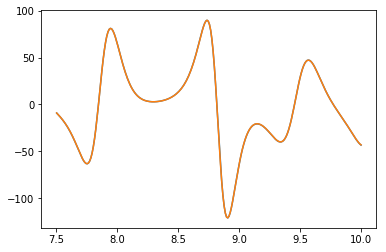

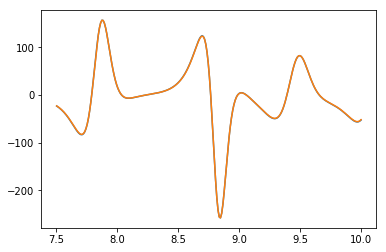

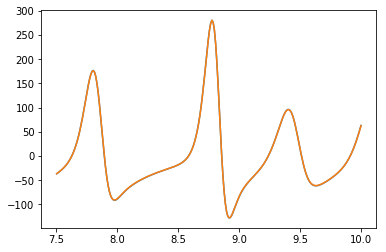

In [8]:
centered_difference = FiniteDifference(order=2, drop_endpoints=False)
for i in range(x_test.shape[1]):
    plt.figure()
    plt.plot(t_test, centered_difference(x_test, t_test)[:,i])
    plt.plot(t_test, model.predict(x_test)[:,i])

## Change some options

In [9]:
from sindy.optimizers import STLSQ, SR3, LASSO
from sklearn.preprocessing import PolynomialFeatures

### SR3

['-0.279  + -10.112  + 10.080 x0', '1.419  + 27.555  + -0.851 x0 + -0.139 x1 + -0.987 1 x1', '-0.245  + 0.250 x0 + -2.593 x1 + 0.985 1 x0']


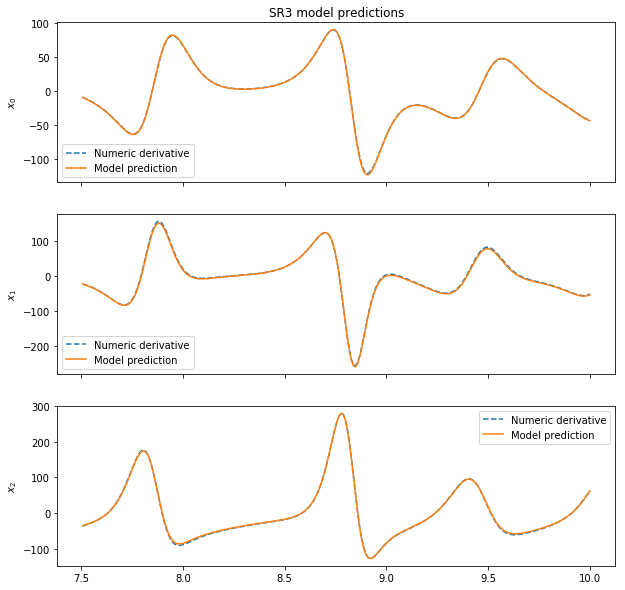

In [25]:
model = SINDy(optimizer=SR3())
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='$x_{}$'.format(i))

axs[0].set(title='SR3 model predictions')
fig.show()

### LASSO

/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


['-0.279  + -10.112  + 10.080 x0 + 0.040 x1 + 0.004 1^2 + -0.001 1 x0 + 0.004 1 x1 + -0.001 x0^2 + -0.003 x0 x1 + -0.001 x1^2', '1.419  + 27.555  + -0.851 x0 + -0.139 x1 + -0.015 1^2 + 0.023 1 x0 + -0.987 1 x1 + -0.011 x0^2 + -0.004 x0 x1 + 0.004 x1^2', '-0.097  + -0.246  + 0.250 x0 + -2.592 x1 + 0.020 1^2 + 0.985 1 x0 + 0.007 1 x1 + -0.002 x0^2 + -0.009 x0 x1 + -0.003 x1^2']


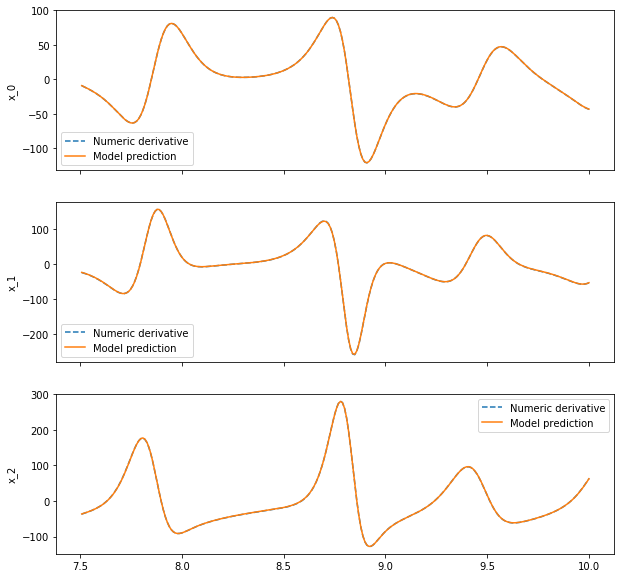

In [11]:
model = SINDy(optimizer=LASSO(max_iter=1000))
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()

## Test SINDy class functions

### Printing model

In [12]:
print(model.get_feature_names())

assert len(model.get_feature_names()) == 10
# Test with larger polynomial library

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [13]:
print(model.equations(precision=2))

['-0.28  + -10.11  + 10.08 x0 + 0.04 x1', '1.42  + 27.56  + -0.85 x0 + -0.14 x1 + -0.02 1^2 + 0.02 1 x0 + -0.99 1 x1 + -0.01 x0^2', '-0.10  + -0.25  + 0.25 x0 + -2.59 x1 + 0.02 1^2 + 0.99 1 x0 + 0.01 1 x1 + -0.01 x0 x1']


In [14]:
print(model.coefficients())

[-2.78924833e-01 -1.01119296e+01  1.00799733e+01  4.02689607e-02
  3.75122903e-03 -8.90220876e-04  3.98413040e-03 -1.40365964e-03
 -3.40056685e-03 -1.13676859e-03]


### Predicting and simulating

In [15]:
model = SINDy()
model.fit(x_train, t_train)

print(model.equations())

['-9.961  + 9.961 x0', '27.559  + -0.922 x0 + -0.988 1 x1', '-2.648 x1 + 0.993 1 x0']


In [16]:
# Standard scoring function is R^2 coefficient of determination
print('(R^2) Score on train set:', model.score(x_train, t=t_train))
print('(R^2) Score on test set:', model.score(x_test, t=t_test))

(R^2) Score on train set: 0.9999419890544722
(R^2) Score on test set: 0.999974329657432


In [20]:
# Other (regression) scoring functions may be used
from sklearn.metrics import mean_squared_error
print('(MSE) Score on train set:', model.score(x_train, t=t_train, metric=mean_squared_error))
print('(MSE) Score on test set:', model.score(x_test, t=t_test, metric=mean_squared_error))

(MSE) Score on train set: 0.6265075423628065
(MSE) Score on test set: 0.13067446473773006


In [18]:
simulated_x = model.simulate(x_test[0, :], t_test)

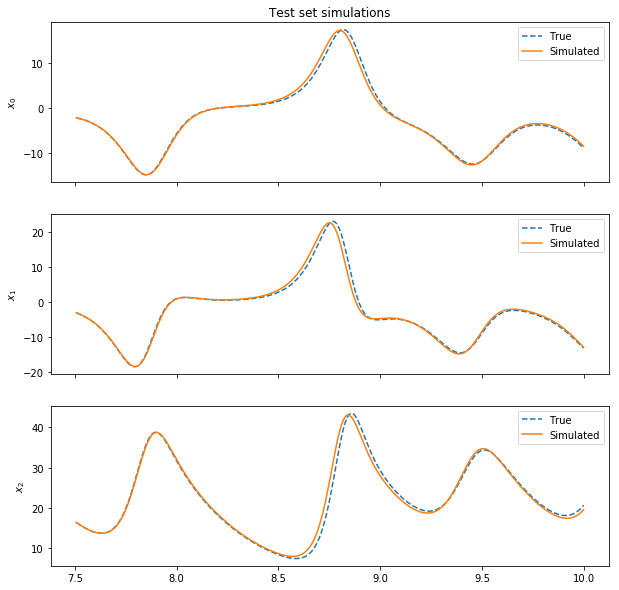

In [21]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:,i], '--', label='True')
    axs[i].plot(t_test, simulated_x[:,i], label='Simulated')
    axs[i].legend()
    axs[i].set(ylabel='$x_{}$'.format(i))

axs[0].set(title='Test set simulations')
fig.show()